In [1]:
import pandas as pd
import dataprep
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('cleaned_loan_data.csv')

In [2]:
display(df)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1,0
1,21.0,0,3,12951.0,0,2,2500.0,5,7.14,0.19,2.0,532,0,1
2,21.0,0,3,12739.0,0,2,1600.0,5,14.74,0.13,3.0,640,0,1
3,24.0,0,4,14283.0,1,0,1750.0,1,10.99,0.12,2.0,679,0,1
4,24.0,0,1,13866.0,0,2,1500.0,4,7.29,0.11,3.0,600,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36060,31.0,1,4,136832.0,9,3,12319.0,4,16.92,0.09,7.0,722,0,1
36061,27.0,0,3,35512.0,4,3,5000.0,4,15.83,0.14,5.0,505,0,1
36062,27.0,1,0,47971.0,6,3,15000.0,3,15.66,0.31,3.0,645,0,1
36063,33.0,1,0,56942.0,7,3,2771.0,0,10.02,0.05,10.0,668,0,1


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Separate features and target
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
# Verify the sizes
print(f"Training set size: {X_train_scaled.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

Training set size: 28852
Test set size: 7213


In [20]:
# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)

# Check the class distribution before and after undersampling
print("Before Undersampling:")
print(y_train.value_counts())
print("\nAfter Undersampling:")
print(pd.Series(y_train_under).value_counts())

Before Undersampling:
0    23021
1     5831
Name: loan_status, dtype: int64

After Undersampling:
0    5831
1    5831
Name: loan_status, dtype: int64


In [21]:
print(f"Training set size: {X_train_under.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

Training set size: 11662
Test set size: 7213


In [4]:
import optuna
import sklearn

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# Replace SVM with CatBoost and MLP
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

In [25]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_under, y_train_under)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Collect evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    # Save results
    results[name] = {"accuracy": accuracy, "report": report, "confusion_matrix": confusion}

Model: Logistic Regression
Accuracy: 0.8420
Classification Report:
{'0': {'precision': 0.9778422033547318, 'recall': 0.820503909643788, 'f1-score': 0.8922902494331065, 'support': 5755.0}, '1': {'precision': 0.5666946308724832, 'recall': 0.9266117969821673, 'f1-score': 0.7032795419052577, 'support': 1458.0}, 'accuracy': 0.8419520310550395, 'macro avg': {'precision': 0.7722684171136075, 'recall': 0.8735578533129778, 'f1-score': 0.7977848956691821, 'support': 7213.0}, 'weighted avg': {'precision': 0.8947348748258093, 'recall': 0.8419520310550395, 'f1-score': 0.8540845636469421, 'support': 7213.0}}
Confusion Matrix:


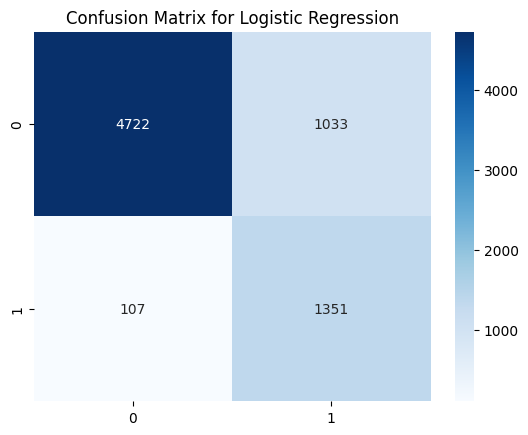

Model: Decision Tree
Accuracy: 0.8585
Classification Report:
{'0': {'precision': 0.9574797062234248, 'recall': 0.8608166811468289, 'f1-score': 0.9065788269741056, 'support': 5755.0}, '1': {'precision': 0.6071603727317313, 'recall': 0.8491083676268861, 'f1-score': 0.708035458964827, 'support': 1458.0}, 'accuracy': 0.8584500207957854, 'macro avg': {'precision': 0.782320039477578, 'recall': 0.8549625243868575, 'f1-score': 0.8073071429694663, 'support': 7213.0}, 'weighted avg': {'precision': 0.8866678958489775, 'recall': 0.8584500207957854, 'f1-score': 0.8664462565377369, 'support': 7213.0}}
Confusion Matrix:


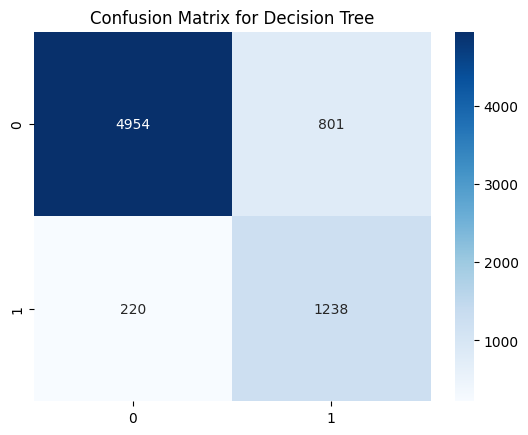

Model: Random Forest
Accuracy: 0.8705
Classification Report:
{'0': {'precision': 0.9764775647361138, 'recall': 0.8583840139009556, 'f1-score': 0.9136304790086924, 'support': 5755.0}, '1': {'precision': 0.6216341689879294, 'recall': 0.9183813443072703, 'f1-score': 0.7414174972314507, 'support': 1458.0}, 'accuracy': 0.8705115763205323, 'macro avg': {'precision': 0.7990558668620216, 'recall': 0.888382679104113, 'f1-score': 0.8275239881200716, 'support': 7213.0}, 'weighted avg': {'precision': 0.9047512828837843, 'recall': 0.8705115763205323, 'f1-score': 0.8788202020876862, 'support': 7213.0}}
Confusion Matrix:


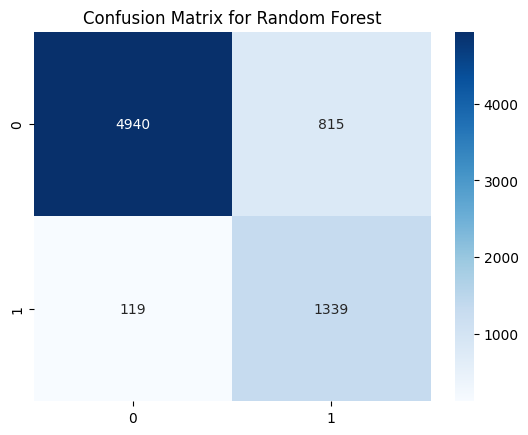

Model: XGBoost
Accuracy: 0.8876
Classification Report:
{'0': {'precision': 0.9779582366589327, 'recall': 0.8788879235447437, 'f1-score': 0.9257801775418688, 'support': 5755.0}, '1': {'precision': 0.658500734933856, 'recall': 0.9218106995884774, 'f1-score': 0.7682194912832238, 'support': 1458.0}, 'accuracy': 0.8875641203382781, 'macro avg': {'precision': 0.8182294857963943, 'recall': 0.9003493115666106, 'f1-score': 0.8469998344125462, 'support': 7213.0}, 'weighted avg': {'precision': 0.9133846836968972, 'recall': 0.8875641203382781, 'f1-score': 0.8939316428732005, 'support': 7213.0}}
Confusion Matrix:


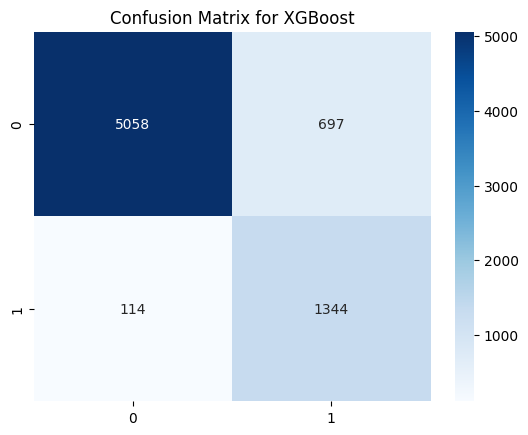

Model: CatBoost
Accuracy: 0.8809
Classification Report:
{'0': {'precision': 0.977751756440281, 'recall': 0.8705473501303215, 'f1-score': 0.9210405368140454, 'support': 5755.0}, '1': {'precision': 0.6433700335088559, 'recall': 0.9218106995884774, 'f1-score': 0.7578235128277417, 'support': 1458.0}, 'accuracy': 0.8809094690142798, 'macro avg': {'precision': 0.8105608949745684, 'recall': 0.8961790248593995, 'f1-score': 0.8394320248208935, 'support': 7213.0}, 'weighted avg': {'precision': 0.9101614955177776, 'recall': 0.8809094690142798, 'f1-score': 0.8880486581266712, 'support': 7213.0}}
Confusion Matrix:


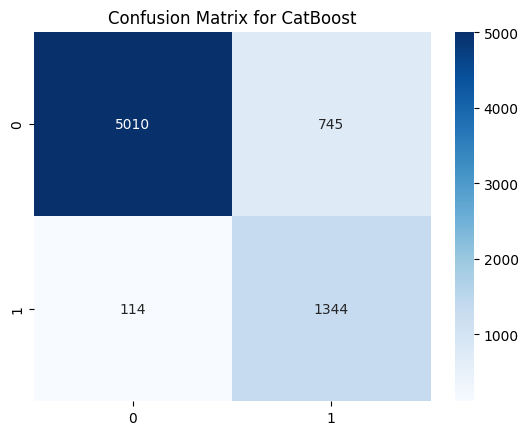

Model: MLP
Accuracy: 0.8535
Classification Report:
{'0': {'precision': 0.9618560755013763, 'recall': 0.8500434404865335, 'f1-score': 0.9024997693939674, 'support': 5755.0}, '1': {'precision': 0.5942642219087917, 'recall': 0.8669410150891632, 'f1-score': 0.7051603905160391, 'support': 1458.0}, 'accuracy': 0.8534590323027866, 'macro avg': {'precision': 0.778060148705084, 'recall': 0.8584922277878484, 'f1-score': 0.8038300799550032, 'support': 7213.0}, 'weighted avg': {'precision': 0.8875528836896491, 'recall': 0.8534590323027866, 'f1-score': 0.8626105673415593, 'support': 7213.0}}
Confusion Matrix:


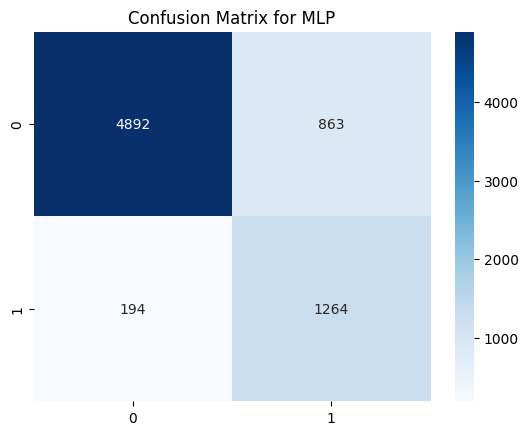

In [26]:
# DataFrame to store results
evaluation_table = pd.DataFrame(columns=["Model", "Loan Status (Encoded)", "Precision", "Recall", "F1 Score", "Support"])

# Visualization of Results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])
    print("Confusion Matrix:")
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    # Add classification report metrics to the table
    rows = []
    for loan_status, metrics in result["report"].items():
        if loan_status.isdigit():  # Filter only numeric health labels (encoded classes)
            rows.append({
                "Model": name,
                "Loan Status (Encoded)": loan_status,
                "Precision": metrics["precision"],
                "Recall": metrics["recall"],
                "F1 Score": metrics["f1-score"],
                "Support": metrics["support"]
            })
    
    # Concatenate rows into the DataFrame
    evaluation_table = pd.concat([evaluation_table, pd.DataFrame(rows)], ignore_index=True)

In [27]:
# Display the evaluation table
print("\nEvaluation Results in Tabular Format:")
evaluation_table


Evaluation Results in Tabular Format:


,Model,Loan Status (Encoded),Precision,Recall,F1 Score,Support
0,Logistic Regression,0,0.977842,0.820504,0.892290,5755.0
1,Logistic Regression,1,0.566695,0.926612,0.703280,1458.0
2,Decision Tree,0,0.957480,0.860817,0.906579,5755.0
3,Decision Tree,1,0.607160,0.849108,0.708035,1458.0
4,Random Forest,0,0.976478,0.858384,0.913630,5755.0
5,Random Forest,1,0.621634,0.918381,0.741417,1458.0
6,XGBoost,0,0.977958,0.878888,0.925780,5755.0
7,XGBoost,1,0.658501,0.921811,0.768219,1458.0
8,CatBoost,0,0.977752,0.870547,0.921041,5755.0
9,CatBoost,1,0.643370,0.921811,0.757824,1458.0


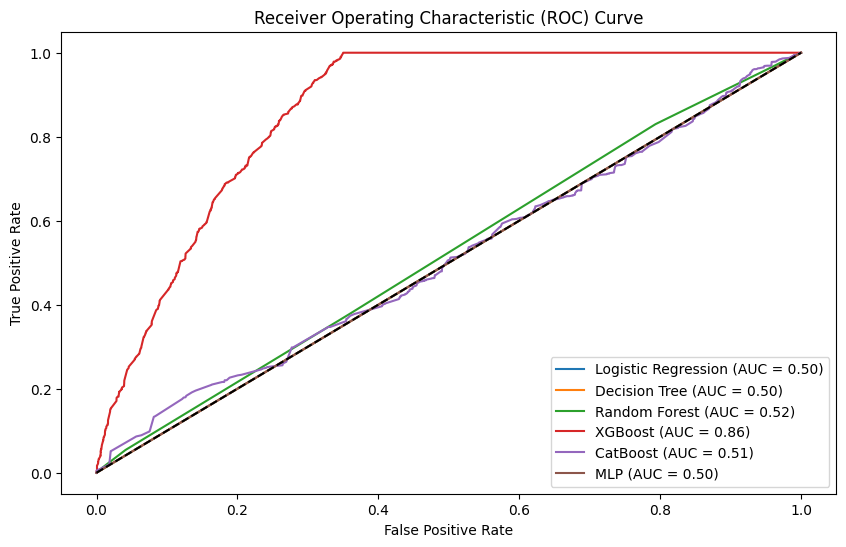

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, result in results.items():
    # Get the model and true labels
    model = models[name]
    y_true = y_test

    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [30]:
# import optuna
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.preprocessing import StandardScaler
# import torch
# from torch import nn, optim
# import numpy as np
# import pandas as pd
# import warnings

# warnings.filterwarnings("ignore")

# # Check for GPU availability
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # Example dataset loading (replace with your own dataset)
# # df = pd.read_csv('your_dataset.csv')
# # Define the objective function for Optuna optimization
# def objective(trial):
#     model_name = trial.suggest_categorical('model',
#                                            ['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'MLP'])

#     # **Decision Tree (CPU Only)**
#     if model_name == 'Decision Tree':
#         model = DecisionTreeClassifier(
#             max_depth=trial.suggest_int('dt_max_depth', 3, 10),
#             min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 10)
#         )

#     # **Logistic Regression (CPU Only)**
#     elif model_name == 'Logistic Regression':
#         model = LogisticRegression(
#             C=trial.suggest_loguniform('lr_C', 0.01, 10),
#             solver='liblinear'
#         )

#     # **Random Forest (CPU Only)**
#     elif model_name == 'Random Forest':
#         model = RandomForestClassifier(
#             n_estimators=trial.suggest_int('rf_n_estimators', 50, 200),
#             max_depth=trial.suggest_int('rf_max_depth', 3, 10)
#         )

#     # **XGBoost with GPU**
#     elif model_name == 'XGBoost':
#         model = XGBClassifier(
#             n_estimators=trial.suggest_int('xgb_n_estimators', 50, 200),
#             max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
#             learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
#             use_label_encoder=False,
#             eval_metric="logloss",
#             tree_method="gpu_hist"
#         )

#     # **CatBoost with GPU**
#     elif model_name == 'CatBoost':
#         model = CatBoostClassifier(
#             iterations=trial.suggest_int('cb_iterations', 50, 200),
#             depth=trial.suggest_int('cb_depth', 3, 10),
#             learning_rate=trial.suggest_float('cb_learning_rate', 0.01, 0.2),
#             task_type="GPU",
#             verbose=0
#         )

#     # **MLP with PyTorch (GPU)**
#     elif model_name == 'MLP':
#         input_dim = X_train_under.shape[1]
#         hidden_dim = trial.suggest_int('mlp_hidden', 50, 200)

#         model = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1),
#             nn.Sigmoid()
#         ).to(device)

#         optimizer = optim.Adam(model.parameters(), lr=0.001)
#         loss_fn = nn.BCELoss()

#         # Convert training data to NumPy and then to PyTorch tensors
#         X_train_array = np.array(X_train_under)
#         y_train_array = np.array(y_train_under)

#         X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32).to(device)
#         y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)

#         # Simple training loop with pruning
#         for epoch in range(3):
#             model.train()
#             optimizer.zero_grad()
#             outputs = model(X_train_tensor).flatten()
#             loss = loss_fn(outputs, y_train_tensor)
#             loss.backward()
#             optimizer.step()

#             # Report progress for pruning
#             trial.report(loss.item(), step=epoch)
#             if trial.should_prune():
#                 raise optuna.exceptions.TrialPruned()

#         # Move test data to GPU for evaluation
#         X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
#         y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)

#         # Predict using PyTorch model
#         model.eval()
#         with torch.no_grad():
#             y_pred = (model(X_test_tensor).flatten() > 0.5).cpu().numpy()
#         accuracy = accuracy_score(y_test, y_pred)
#         return accuracy

#     # For all other models (Scikit-Learn)
#     model.fit(X_train_under, y_train_under)
#     y_pred = model.predict(X_test_scaled)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

# # Run Optuna study with pruning enabled
# study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study.optimize(objective, n_trials=50)

# # Display the best model and hyperparameters
# print("\n🎯 Best Model and Hyperparameters:")
# print(f"Best Model: {study.best_params['model']}")
# print(f"Best Accuracy: {study.best_value:.4f}")
# print(f"Best Hyperparameters: {study.best_params}")

[I 2025-01-16 22:20:15,255] A new study created in memory with name: no-name-efe55e9c-b57c-49e2-b5fc-b2e175f9dec5


Using device: cuda


[I 2025-01-16 22:20:15,917] Trial 0 finished with value: 0.8325246083460419 and parameters: {'model': 'Random Forest', 'rf_n_estimators': 114, 'rf_max_depth': 5}. Best is trial 0 with value: 0.8325246083460419.
[I 2025-01-16 22:20:15,957] Trial 1 finished with value: 0.8418133924857896 and parameters: {'model': 'Logistic Regression', 'lr_C': 6.016218737687517}. Best is trial 1 with value: 0.8418133924857896.
[I 2025-01-16 22:20:16,643] Trial 2 finished with value: 0.884098156107029 and parameters: {'model': 'XGBoost', 'xgb_n_estimators': 85, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.1848847796698169}. Best is trial 2 with value: 0.884098156107029.
[I 2025-01-16 22:20:16,668] Trial 3 finished with value: 0.8418133924857896 and parameters: {'model': 'Logistic Regression', 'lr_C': 0.28223294243298586}. Best is trial 2 with value: 0.884098156107029.
[I 2025-01-16 22:20:17,334] Trial 4 finished with value: 0.8596977679190351 and parameters: {'model': 'Random Forest', 'rf_n_estimators': 82

KeyboardInterrupt: 